<a href="https://colab.research.google.com/github/udaydarade/NIFTY50_prediction_using_ARIMA_and_LSTM/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving NIFTY_50_Data.csv to NIFTY_50_Data (3).csv
Best ARIMA order: (1, 0, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Epoch 1: Train RMSE = 1023.2922, Validation RMSE = 1575.5628
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 859ms/step - loss: 0.1113 - val_loss: 0.0299
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Epoch 2: Train RMSE = 873.0283, Validation RMSE = 1342.3868
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 686ms/step - loss: 0.0180 - val_loss: 0.0507
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Epoch 3: Train RMSE = 985.0059, Validation RMSE = 1545.2522
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - loss: 0.0139 - val_loss: 0.0309
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Epoch 4: Train RMSE = 1017.8303, Validation RMSE = 1658.9735
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - loss: 0.0114 - val_loss: 0.0233
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Epo

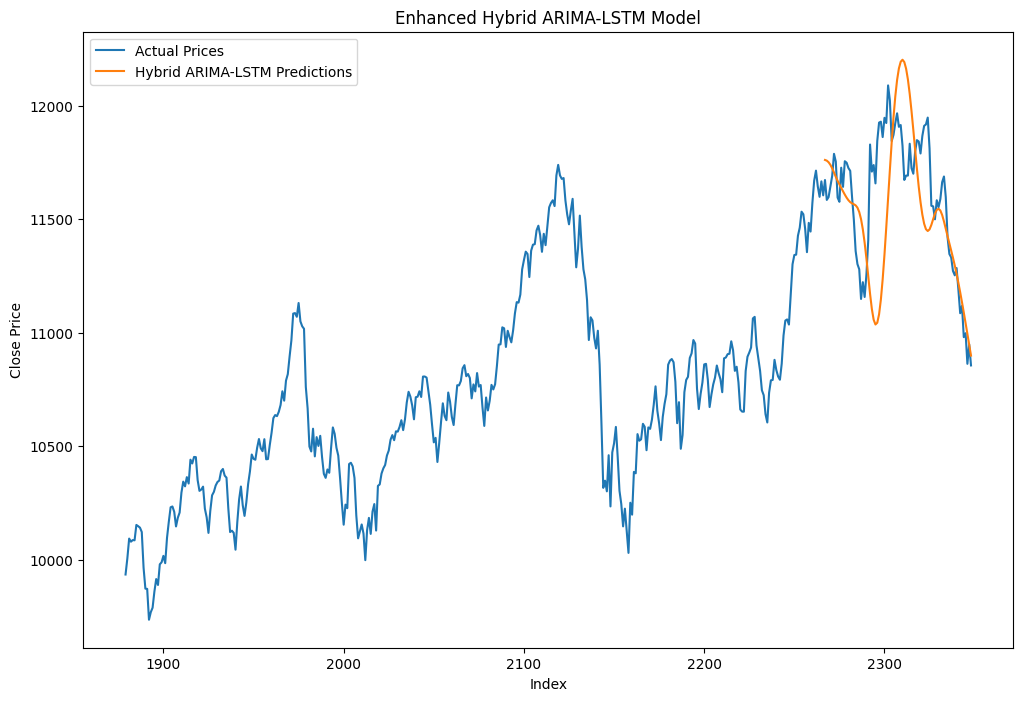

Enhanced Hybrid ARIMA-LSTM RMSE: 309.0694721691448


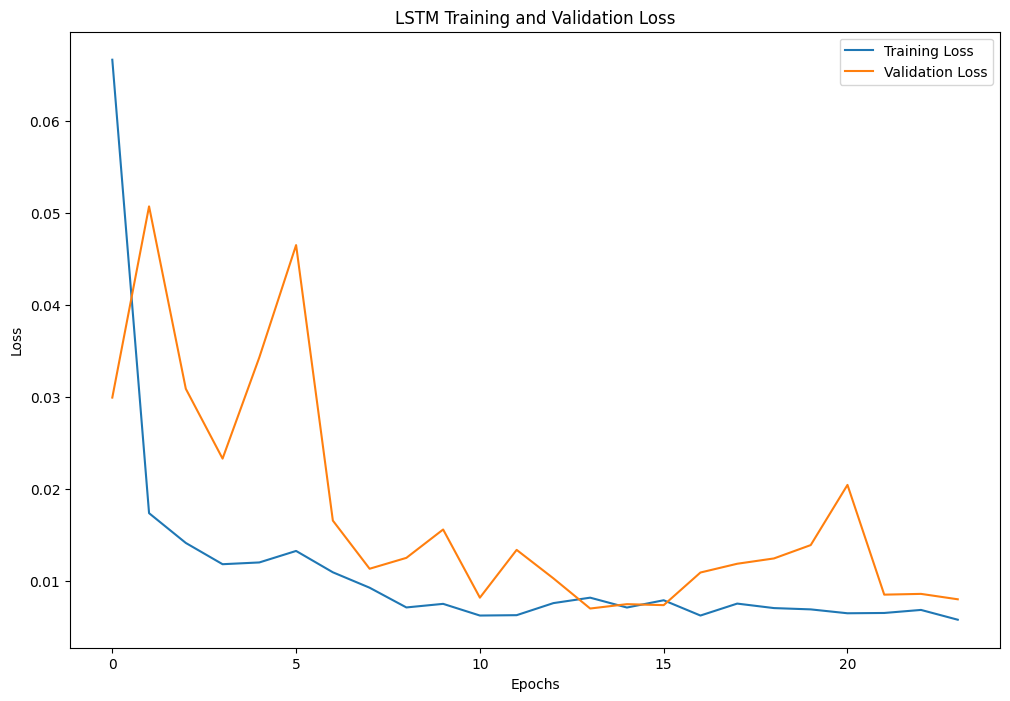

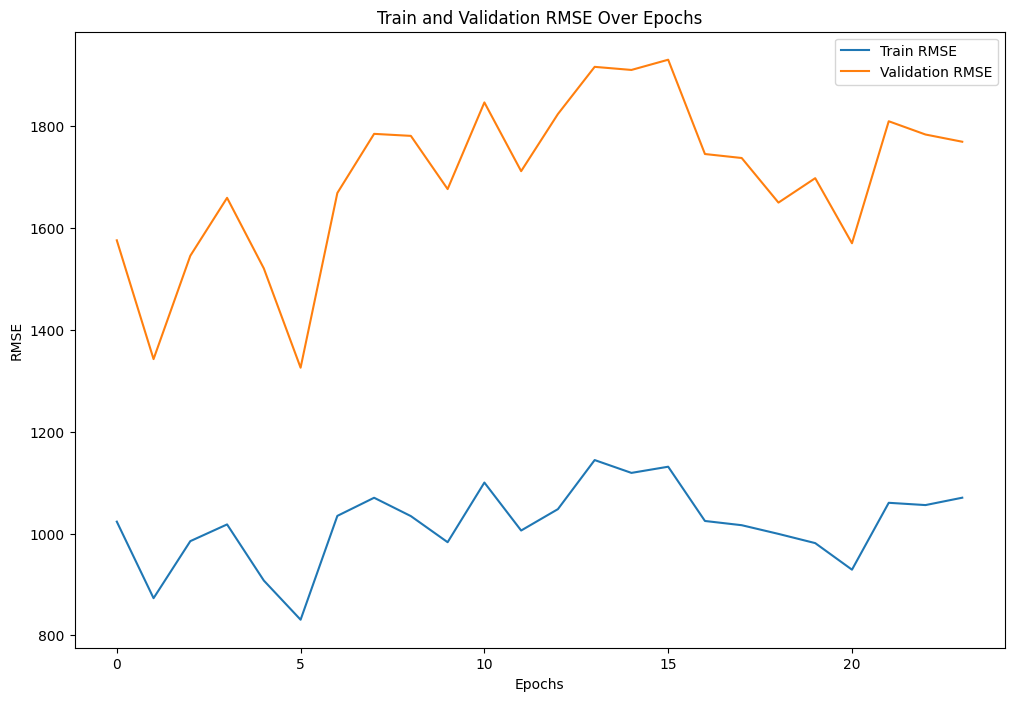

In [5]:
# Import necessary libraries
from google.colab import files
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
# Upload the file
uploaded = files.upload()

# Load the NIFTY 50 dataset
df = pd.read_csv('NIFTY_50_Data.csv')
df.reset_index(drop=True, inplace=True)

# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df['Close'].iloc[:train_size], df['Close'].iloc[train_size:]

# ARIMA Model with Grid Search for Best Order
best_order = None
best_aic = np.inf
p_values = range(1, 5)
d_values = range(0, 1)
q_values = range(1, 5)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
            except:
                continue

print(f'Best ARIMA order: {best_order}')

# Fit the ARIMA model with the best order
arima_model = ARIMA(train, order=best_order)
arima_model_fit = arima_model.fit()

# Forecast using ARIMA
arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_forecast = pd.Series(arima_forecast, index=test.index)

# Calculate the residuals from ARIMA
residuals = test - arima_forecast

# LSTM Model on Residuals

# Preprocessing for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

look_back = 60
X, y = create_dataset(scaled_residuals, look_back)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Custom Callback to Calculate RMSE
class RMSECallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_rmse = []
        self.val_rmse = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = self.model.predict(X_train)
        train_pred = scaler.inverse_transform(train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred.flatten()))

        val_pred = self.model.predict(X_test)
        val_pred = scaler.inverse_transform(val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_test, val_pred.flatten()))

        self.train_rmse.append(train_rmse)
        self.val_rmse.append(val_rmse)

        print(f'Epoch {epoch+1}: Train RMSE = {train_rmse:.4f}, Validation RMSE = {val_rmse:.4f}')

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=16))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
)


# Train the model with validation split, more epochs, RMSE callback, and EarlyStopping
rmse_callback = RMSECallback()
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[rmse_callback, early_stopping]  # Add EarlyStopping to the list of callbacks
)

# LSTM Predictions
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Combine ARIMA and LSTM predictions
final_predictions = arima_forecast.values[-len(lstm_predictions):] + lstm_predictions.flatten()

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(test.index, test.values, label='Actual Prices')
plt.plot(test.index[-len(final_predictions):], final_predictions, label='Hybrid ARIMA-LSTM Predictions')
plt.title('Enhanced Hybrid ARIMA-LSTM Model')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test[-len(final_predictions):], final_predictions))
print(f'Enhanced Hybrid ARIMA-LSTM RMSE: {rmse}')

# Plot training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE over epochs
plt.figure(figsize=(12, 8))
plt.plot(rmse_callback.train_rmse, label='Train RMSE')
plt.plot(rmse_callback.val_rmse, label='Validation RMSE')
plt.title('Train and Validation RMSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()
